In [1]:
import pandas as pd
import numpy as np

medsCohort = pd.read_stata("/Users/burke/Documents/research/bpCog/meds.dta")
medsCohort['antiHypertensiveCount'] = medsCohort[['medsbpace', 'medsbparb', 'medsbpalphabs', 'medsbpbetabs', 'medsbpcalbs', 'medsbpdiur', 'medsbprenin', 'medsbpvas', 'medsbpoth', 'afibslfrep', 'Hxafib', 'afibinc',]].sum(axis=1)
medsCohort['statin'] = medsCohort.medsstatinshchol
medsCohort['afib'] = medsCohort.index.isin(medsCohort.loc[(medsCohort.afibslfrep==1) |  (medsCohort.Hxafib == 1) | (medsCohort.afibinc == 1)].index)
medsCohort['afib'] = medsCohort['afib'].astype('int')

medsCohort= medsCohort[['newid', 'antiHypertensiveCount', 'statin', 'visitcounter', 'afib']]

completeCohort = pd.read_stata("/Users/burke/Documents/research/bpCog/combinedCohort.dta")

#completeCohort =  pd.read_csv("/Users/burke/Documents/research/bpCog/combinedCohort.csv", low_memory=False)

In [2]:
completeCohort['newid'] = completeCohort['newid'].str[2:-1]

In [3]:
medsCohort.head()

,newid,antiHypertensiveCount,statin,visitcounter,afib
0,100016012504cardia,0.0,NaN,1,0
1,100016012504cardia,0.0,NaN,2,0
2,100016012504cardia,0.0,NaN,3,0
3,100016012504cardia,0.0,NaN,4,0
4,100023004268cardia,0.0,NaN,1,0


In [4]:
completeCohort.drop(labels=['afibinc', 'hxafib', 'afibslfrep', 'ttoafib', 'afibdt', 'afib'], axis='columns', inplace=True)
completeCohort = completeCohort.merge(medsCohort, how='left', on=['newid', 'visitcounter'])

In [5]:
completeCohort.drop(labels=['sbpavg', 'dbpavg'], axis='columns', inplace=True)
completeCohort['sbpavg'] = completeCohort[['sbp1', 'sbp2', 'sbp3']].mean(axis=1)
completeCohort['dbpavg'] = completeCohort[['dbp1', 'dbp2', 'dbp3']].mean(axis=1)

In [6]:
completeCohort.racebpcog.value_counts()

2    177722
1     61078
3     36458
9      5528
Name: racebpcog, dtype: int64

In [7]:
cohort = completeCohort[['newid', 'visitcounter', 'sbpavg', 'dbpavg', 'bmi', 'trig', 'smokestatus', 'choltot', 'cholhdl', 'cholldl', 
                 'age0', 'female0', 'educ0', 'daysfromvisit1', 'racebpcog', 'hba1c', 'glucosef', 'educ0', 'physact', 'waistcm',
                 'antiHypertensiveCount', 'statin', 'afib']]

# build a clean new index in the cohort using the newid groups
cohort = cohort.assign(id=(cohort['newid']).astype('category').cat.codes)
cohort.drop(labels=['newid'], axis='columns', inplace=True)

cohort.rename(columns={'sbpavg' : 'sbp', 'dbpavg' : 'dbp', 'smokestatus' : 'smokingStatus', 'choltot' : 'totChol',
                      "cholhdl" : 'hdl', 'cholldl' : 'ldl', 'age0' : 'baseAge', 'female0' : 'gender', 'educ0' : 'education',
                      'hba1c' : 'a1c', 'racebpcog' : 'raceEthnicity', 'waistcm' : 'waist', 'physact' : 'anyPhysicalActivity'}, inplace=True)


cohort = cohort.loc[:,~cohort.columns.duplicated()]


cohort.gender.replace(to_replace=[0,1], value=[1, 2], inplace=True)
# have to compress "hispanic" to "other hispanic" and no representation for mexican american in BP Cog
cohort.raceEthnicity = cohort.raceEthnicity.replace({1 : 4, 2 : 3,3 : 2,9 : 5}) 

In [8]:
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi", "dbp", "sbp", "ldl", "trig", "glucosef", "waist", "anyPhysicalActivity", 'afib', 'antiHypertensiveCount', 'statin']

lagVars = []

# first geneate lag variables which we'll use in teh imputation
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    lagVars.append(newVarName)
    cohort[newVarName] = cohort.groupby(['id'])[factor].shift(1)
    cohort = cohort.join(other=cohort.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    cohort.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)
cohort.drop(lagVars, axis='columns', inplace=True)

cohort['age'] = cohort.baseAge + cohort.daysfromvisit1 / 365
cohort = pd.concat([cohort, pd.get_dummies(cohort['raceEthnicity'], prefix="raceEth")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['smokingStatus'], prefix="smoke")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['education'], prefix="educ")], axis=1)


cohort.drop(['baseAge', 'daysfromvisit1', 'visitcounter', 'smokingStatus', 'raceEthnicity', 'education'], axis='columns', inplace=True)

cohort.rename(columns={'raceEth_2' : 'raceEth2', 'raceEth_3' : 'raceEth3', 'raceEth_4' : 'raceEth4',
                        'raceEth_5' : 'raceEth5', 'smoke_0.0' : 'smoke0', 'smoke_1.0' : 'smoke1' , 
                       'smoke_2.0' : 'smoke2', 'educ_1.0' : 'educ1', 'educ_2.0' : 'educ2', 'educ_3.0' : 'educ3',
                      'educ_4.0' : 'educ4', 'educ_5.0' : 'educ5'}, inplace=True)


In [9]:
import statsmodels.imputation.mice as mice

def getFormulaForVariable(var):
    cols = list(cohort.columns)
    cols.remove(var)
    colStrings = [col + "+"for col in cols]
    return "".join(colStrings)[:-1]
    
imputedCohort = mice.MICEData(cohort)
#binaryVars = ['anyPhysicalActivity', 'smoke0', 'smoke1', 'smoke2', 'raceEth2', 'raceEth3', 'raceEth4', 'raceEth5', 'educ1', 'educ2', 'educ3', 'educ4', 'educ5']
#for var in binaryVars: 
#    imputedCohort.set_imputer(var, formula=getFormulaForVariable(var), model_class="logit")
imputedCohort.update_all(20)

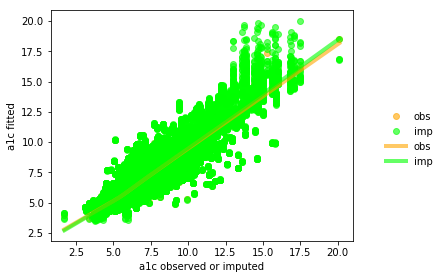

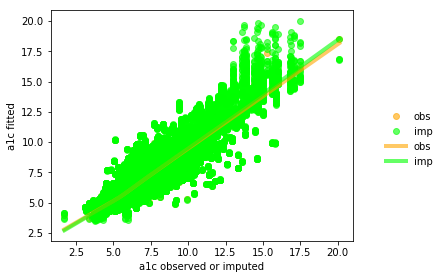

In [10]:
%matplotlib inline
imputedCohort.plot_fit_obs("a1c")

In [11]:
imputedData = imputedCohort.data.copy()

# rebvuild categoricals
imputedData['smokingStatus'] = imputedData[['smoke0', 'smoke1', 'smoke2']].idxmax(axis=1)
imputedData['smokingStatus'] = imputedData['smokingStatus'].str[-1:]
imputedData['raceEthnicity'] = imputedData[['raceEth2', 'raceEth3', 'raceEth4', 'raceEth5']].idxmax(axis=1)
imputedData['raceEthnicity'] = imputedData['raceEthnicity'].str[-1:]

In [12]:
# drop the dummies
imputedData.drop(['smoke0', 'smoke1','smoke2'], axis='columns', inplace=True)
imputedData.drop(['raceEth2', 'raceEth3','raceEth3', 'raceEth4', 'raceEth5'], axis='columns', inplace=True)
imputedData.drop(['educ1', 'educ2','educ3', 'educ4', 'educ5'], axis='columns', inplace=True)
imputedData.drop(list(imputedData.filter(regex='mean')), axis='columns', inplace=True)
# drop the mean variables (they were partially imputed)

In [13]:
# rebuild the mean variables off the impuated values
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi","ldl", "trig", "glucosef",  "waist", "anyPhysicalActivity", "antiHypertensiveCount", "statin", "afib"]
logFactorsImputation = ["dbp", "sbp"]

In [14]:
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)

In [15]:
for factor in logFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    logLagName = "log" + newVarName[0].upper() + newVarName[1:]
    logName = "log" + factor[0].upper() + factor[1:]

    imputedData[logName] = np.log(imputedData[factor])  
    imputedData[logLagName] = np.log(imputedData[newVarName])  
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[logLagName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={logLagName + "mean" : 'mean' + logLagName[0].upper() + logLagName[1:]}, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [16]:
imputedData.raceEthnicity= imputedData.raceEthnicity.astype('category')
imputedData.smokingStatus= imputedData.smokingStatus.astype('category')
imputedData.sort_values(by=['id', 'age'], inplace=True)

In [17]:
imputedData.raceEthnicity.value_counts()

3    177722
4     61078
2     36458
5      5528
Name: raceEthnicity, dtype: int64

In [18]:
import statsmodels.formula.api as statsmodel
import sys
import os
sys.path.append(os.path.abspath("../mcm/"))
from mcm.regression_model import RegressionModel

regResults = {}

def buildAndExportRegressionModelForDataset(outcomeVariable , fullDataset, hasLog): 
    factors = allFactors.copy()
    factors.extend(logFactors)
    factors.remove(outcomeVariable)
    factors = ["mean" + factor[0].upper() + factor[1:] + " + " + factor + " + " for factor in factors] 
    
    meanLagOutcomeVariable =  "mean" + outcomeVariable[0].upper() + outcomeVariable[1:]
    
    if (not hasLog):
        outcomeVariable = outcomeVariable[3:4].lower() + outcomeVariable[4:] # remove the lag
    else:
        outcomeVariable = "log" + outcomeVariable[-3:] # remove the lag and add the log
    
    formula = outcomeVariable + " ~ " + "".join(factors) + "age + gender + smokingStatus + raceEthnicity + " + meanLagOutcomeVariable

    print("outcome: " + outcomeVariable + " hasLog: " + str(hasLog) + " : " +formula)

    model = statsmodel.ols(formula=formula, data=fullDataset)
    results = model.fit()
    regResults[outcomeVariable] = results
    mcmRegressionModel = RegressionModel(results.params.to_dict(), results.bse.to_dict(), results.resid.mean(), results.resid.std())
    mcmRegressionModel.write_json(os.path.abspath("../mcm/mcm/data/" + outcomeVariable + "CohortModelSpec.json"))
    #results.save("/Users/burke/Documents/research/bpCog/mcm/mcm/data/" + outcomeVariable +  "CohortModel.pickle")
    return results


allFactors = ["lagA1c", "lagHdl", "lagTotChol", "lagBmi", "lagLdl", "lagTrig", "lagWaist", "lagAnyPhysicalActivity", "lagAntiHypertensiveCount", "lagStatin", "lagAfib"]
logFactors = ["logLagDbp", "logLagSbp"]

imputedData['logDbp'].loc[imputedData['logDbp'] <= 0] = imputedData['logDbp'].loc[imputedData['logDbp']> 0].min()
imputedData['logLagDbp'].loc[imputedData['logLagDbp'] <= 0] = imputedData['logLagDbp'].loc[imputedData['logLagDbp']> 0].min()
imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp'] <= 0] = imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp']> 0].min()



for factor in allFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, False)
for factor in logFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, True)
    

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


outcome: a1c hasLog: False : a1c ~ meanLagHdl + lagHdl + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLagWaist + lagWaist + meanLagAnyPhysicalActivity + lagAnyPhysicalActivity + meanLagAntiHypertensiveCount + lagAntiHypertensiveCount + meanLagStatin + lagStatin + meanLagAfib + lagAfib + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagA1c
outcome: hdl hasLog: False : hdl ~ meanLagA1c + lagA1c + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLagWaist + lagWaist + meanLagAnyPhysicalActivity + lagAnyPhysicalActivity + meanLagAntiHypertensiveCount + lagAntiHypertensiveCount + meanLagStatin + lagStatin + meanLagAfib + lagAfib + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagHdl
outcome: totChol hasLog: False : totChol ~ meanLagA1c + lagA1c + meanLagHdl + lagH

In [19]:
imputedData.anyPhysicalActivity.value_counts(normalize=True)

1.0    0.8117
0.0    0.1883
Name: anyPhysicalActivity, dtype: float64

In [20]:
regResults['logSbp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logSbp   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                 1.274e+04
Date:                Thu, 04 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:47:37   Log-Likelihood:             2.2899e+05
No. Observations:              239623   AIC:                        -4.579e+05
Df Residuals:                  239590   BIC:                        -4.576e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0907      0.008     10.695      0.000       0.074       0.107
smokingStatus[T.1]               0.0022      0.000      4.572      0.000       0.001       0.003
smokingStatus[T.2]               0.0021      0.001      3.148      0.002       0.001       0.003
raceEthnicity[T.3]              -0.0032      0.001     -5.070      0.000      -0.004      -0.002
raceEthnicity[T.4]              -0.0015      0.001     -2.083      0.037      -0.003   -8.93e-05
raceEthnicity[T.5]               0.0030      0.001      2.027      0.043       0.000       0.006
meanLagA1c                       0.0004      0.000      1.290      0.197      -0.000       0.001
lagA1c                           0.0002      0.000      0.608      0.543      -0.000       0.001
meanLagHdl                       0.0005      0.000      2.501      0.012       0.000       0.001
lagHdl                        8.891e-05      0.000      0.764      0.445      -0.000       0.000
meanLagTotChol                  -0.0006      0.000     -2.671      0.008      -0.001      -0.000
lagTotChol                    2.678e-05      0.000      0.243      0.808      -0.000       0.000
meanLagBmi                      -0.0007      0.000     -4.368      0.000      -0.001      -0.000
lagBmi                          -0.0006      0.000     -4.359      0.000      -0.001      -0.000
meanLagLdl                       0.0006      0.000      2.804      0.005       0.000       0.001
lagLdl                        5.828e-05      0.000      0.530      0.596      -0.000       0.000
meanLagTrig                      0.0001   4.08e-05      2.471      0.013    2.08e-05       0.000
lagTrig                       2.617e-06   2.08e-05      0.126      0.900   -3.81e-05    4.33e-05
meanLagWaist                     0.0007   5.49e-05     12.920      0.000       0.001       0.001
lagWaist                        -0.0002   4.16e-05     -4.017      0.000      -0.000   -8.56e-05
meanLagAnyPhysicalActivity      -0.0032      0.001     -2.701      0.007      -0.006      -0.001
lagAnyPhysicalActivity           0.0002      0.001      0.161      0.872      -0.002       0.002
meanLagAntiHypertensiveCount     0.0066      0.000     13.208      0.000       0.006       0.008
lagAntiHypertensiveCount        -0.0073      0.000    -18.768      0.000      -0.008      -0.007
meanLagStatin                   -0.0016      0.001     -1.321      0.186      -0.004       0.001
lagStatin                        0.0035      0.001      3.818      0.000       0.002       0.005
meanLagAfib                      0.0104      0.002      4.633      0.000       0.006       0.015
lagAfib                         -0.0120      0.002     -6.691      0.000      -0.015      -0.008
meanLogLagDbp                   -0.0023      0.002     -1.328      0.184    

In [21]:
regResults['afib'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   afib   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Thu, 04 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:47:37   Log-Likelihood:             1.5189e+05
No. Observations:              239623   AIC:                        -3.037e+05
Df Residuals:                  239590   BIC:                        -3.034e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0018      0.012      0.154      0.877      -0.021       0.025
smokingStatus[T.1]              -0.0038      0.001     -5.725      0.000      -0.005      -0.003
smokingStatus[T.2]               0.0011      0.001      1.235      0.217      -0.001       0.003
raceEthnicity[T.3]               0.0081      0.001      9.279      0.000       0.006       0.010
raceEthnicity[T.4]               0.0045      0.001      4.543      0.000       0.003       0.006
raceEthnicity[T.5]               0.0029      0.002      1.396      0.163      -0.001       0.007
meanLagA1c                      -0.0019      0.000     -3.970      0.000      -0.003      -0.001
lagA1c                           0.0021      0.000      5.437      0.000       0.001       0.003
meanLagHdl                      -0.0005      0.000     -1.606      0.108      -0.001       0.000
lagHdl                           0.0003      0.000      2.108      0.035    2.38e-05       0.001
meanLagTotChol                   0.0005      0.000      1.714      0.087   -7.15e-05       0.001
lagTotChol                      -0.0005      0.000     -3.345      0.001      -0.001      -0.000
meanLagBmi                       0.0043      0.000     18.298      0.000       0.004       0.005
lagBmi                          -0.0026      0.000    -13.397      0.000      -0.003      -0.002
meanLagLdl                      -0.0004      0.000     -1.388      0.165      -0.001       0.000
lagLdl                           0.0004      0.000      2.402      0.016     6.7e-05       0.001
meanLagTrig                  -6.353e-05   5.62e-05     -1.129      0.259      -0.000    4.67e-05
lagTrig                       6.067e-05   2.86e-05      2.118      0.034    4.54e-06       0.000
meanLagWaist                    -0.0011   7.58e-05    -14.264      0.000      -0.001      -0.001
lagWaist                         0.0004   5.74e-05      6.589      0.000       0.000       0.000
meanLagAnyPhysicalActivity       0.0176      0.002     10.719      0.000       0.014       0.021
lagAnyPhysicalActivity          -0.0133      0.001     -9.436      0.000      -0.016      -0.011
meanLagAntiHypertensiveCount    -0.0635      0.001    -96.010      0.000      -0.065      -0.062
lagAntiHypertensiveCount         0.0635      0.001    125.285      0.000       0.062       0.064
meanLagStatin                   -0.0156      0.002     -9.298      0.000      -0.019      -0.012
lagStatin                        0.0134      0.001     10.641      0.000       0.011       0.016
meanLogLagDbp                    0.0036      0.003      1.385      0.166      -0.001       0.009
logLagDbp                        0.0133      0.002      5.378      0.000       0.008       0.018
meanLogLagSbp                    0.0110      0.004      2.493      0.013    

ok...mdels are looking a bit bette rnow. sbp model looks reasonbly close to stata model which is reassureing.

other thought...
if we systematically name the variables here, it may be relatively easy to build a risk model apparatus that reads from these files and implements them. so, "log" means that the predictor is log-transformed. "meanLab" means that you take the maen of all prior values. "lag" means that you take the the value immediately before.

then you can include variable names in snake case — so each variable is multiple in. you'd be able to specify multi-way interactions or quadratic terms pretty easily that way... 